<h1>Data Mining
<h3>W05 - Class Practice

Tiffany Christabel Anggriawan - 0706022310041

<h3>Data Preprocessing

Load and inspect the dataset

In [3]:
!pip install category_encoders==2.6.3

   ---------------------------------------- 0.0/81.9 kB ? eta -:--:--
   ----- ---------------------------------- 10.2/81.9 kB ? eta -:--:--
   ---------- ----------------------------- 20.5/81.9 kB 330.3 kB/s eta 0:00:01
   -------------------- ------------------- 41.0/81.9 kB 393.8 kB/s eta 0:00:01
   ---------------------------------------- 81.9/81.9 kB 511.6 kB/s eta 0:00:00
  Attempting uninstall: category_encoders
    Found existing installation: category-encoders 2.6.1
    Uninstalling category-encoders-2.6.1:
      Successfully uninstalled category-encoders-2.6.1


In [5]:
pip install scikit-learn==1.4.2

   ---------------------------------------- 0.0/10.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/10.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/10.6 MB 325.1 kB/s eta 0:00:33
   ---------------------------------------- 0.1/10.6 MB 930.9 kB/s eta 0:00:12
    --------------------------------------- 0.2/10.6 MB 1.2 MB/s eta 0:00:09
    --------------------------------------- 0.2/10.6 MB 1.1 MB/s eta 0:00:10
    --------------------------------------- 0.2/10.6 MB 1.1 MB/s eta 0:00:10
    --------------------------------------- 0.2/10.6 MB 1.1 MB/s eta 0:00:10
    --------------------------------------- 0.2/10.6 MB 1.1 MB/s eta 0:00:10
    --------------------------------------- 0.2/10.6 MB 1.1 MB/s eta 0:00:10
    --------------------------------------- 0.2/10.6 MB 1.1 MB/s eta 0:00:10
    --------------------------------------- 0.2/10.6 MB 1.1 MB/s eta 0:00:10
    --------------------------------------- 0.2/10.6 MB 1.1 MB/s eta 0:00:10
    -----

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.8.1 requires scikit-learn>=1.6.0, but you have scikit-learn 1.4.2 which is incompatible.


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import compute_class_weight

import category_encoders as ce
from imblearn.over_sampling import SMOTE, RandomOverSampler

In [5]:
DATA_URL = 'https://raw.githubusercontent.com/NathaliaMinoque/datasets/refs/heads/main/exercise_employee_attrition.csv'

df = pd.read_csv(DATA_URL)

In [6]:
print('Rows, cols:', df.shape)
print(df.head())
print('\nColumn types:')
print(df.dtypes)

Rows, cols: (1000, 26)
   Employee_ID  Age  Gender Marital_Status Department   Job_Role  Job_Level  \
0            1   58  Female        Married         IT    Manager          1   
1            2   48  Female        Married      Sales  Assistant          5   
2            3   34    Male        Married  Marketing  Assistant          1   
3            4   27  Female       Divorced  Marketing    Manager          1   
4            5   40    Male       Divorced  Marketing  Executive          1   

   Monthly_Income  Hourly_Rate  Years_at_Company  ...  Overtime  \
0           15488           28                15  ...        No   
1           13079           28                 6  ...       Yes   
2           13744           24                24  ...       Yes   
3            6809           26                10  ...        No   
4           10206           52                29  ...        No   

   Project_Count  Average_Hours_Worked_Per_Week  Absenteeism  \
0              6                   

Handle missing or inconsistent data

In [9]:
if 'Employee_ID' in df.columns:
    df = df.drop(columns=['Employee_ID'])

In [10]:
print('\nMissing values per column:')
print(df.isna().sum())


Missing values per column:
Age                              0
Gender                           0
Marital_Status                   0
Department                       0
Job_Role                         0
Job_Level                        0
Monthly_Income                   0
Hourly_Rate                      0
Years_at_Company                 0
Years_in_Current_Role            0
Years_Since_Last_Promotion       0
Work_Life_Balance                0
Job_Satisfaction                 0
Performance_Rating               0
Training_Hours_Last_Year         0
Overtime                         0
Project_Count                    0
Average_Hours_Worked_Per_Week    0
Absenteeism                      0
Work_Environment_Satisfaction    0
Relationship_with_Manager        0
Job_Involvement                  0
Distance_From_Home               0
Number_of_Companies_Worked       0
Attrition                        0
dtype: int64


In [11]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = df.select_dtypes(include=['object']).columns.tolist()

In [13]:
TARGET = 'Attrition'
if df[TARGET].dtype == 'object':
    df[TARGET] = df[TARGET].map({'Yes':1, 'No':0})

In [14]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

Encode categorical features appropriately

In [15]:
ordinal_cols = [c for c in ['Work_Life_Balance','Job_Satisfaction','Performance_Rating','Work_Environment_Satisfaction','Relationship_with_Manager','Job_Involvement'] if c in df.columns]
nominal_cols = [c for c in cat_cols if c not in ordinal_cols and c != TARGET]

In [16]:
ordinal_mappings = {}
for col in ordinal_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

In [17]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('target_enc', ce.TargetEncoder())
])

In [18]:
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_cols),
    ('cat', categorical_transformer, nominal_cols)
])

#### 5. Create comprehensive preprocessing pipeline

Partition the data into training and testing sets

In [19]:
X = df.drop(columns=[TARGET])
y = df[TARGET]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

print('\nClass distribution in train:', np.bincount(y_train))
print('Class distribution in test :', np.bincount(y_test))


Class distribution in train: [649 151]
Class distribution in test : [162  38]


In [20]:
ratio = (y_train==0).sum() / (y_train==1).sum()
print('\nImbalance ratio (major/minor):', ratio)


Imbalance ratio (major/minor): 4.298013245033113


#### Check class imbalance

<h3>Model Development

Use Decision Tree classification models

In [22]:
baseline_pipeline = Pipeline(steps=[
    ('pre', preprocessor),
    ('clf', DecisionTreeClassifier(random_state=42))
])

Hyperparameter tuning using GridSearchCV or manual parameter testing & evaluate performance using k-fold cross-validation

In [23]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
baseline_scores = cross_val_score(baseline_pipeline, X_train, y_train, scoring='f1', cv=cv)
print('\nBaseline CV F1 scores:', baseline_scores)
print('Baseline CV F1 mean:', baseline_scores.mean())


Baseline CV F1 scores: [0.19230769 0.22222222 0.21538462 0.17647059 0.03333333]
Baseline CV F1 mean: 0.16794369029663148


In [24]:
rf_pipe = Pipeline(steps=[('pre', preprocessor), ('rf', RandomForestClassifier(n_estimators=100, random_state=42))])
rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Job_Level',
                                                   'Monthly_Income',
                                                   'Hourly_Rate',
                                                   'Years_at_Company',
                                                   'Years_in_Current_Role',
                                                   'Years_Since_Last_Promotion',
                                                   'Work_Life_Balance',
                                                   'Job_Satisfaction',
                                                   'Performance_Rating',
                                                   'Training_Hours...
                                                   'Work_Environment_Satisfaction',
                                                   'Relationship_with_Manager',
                                                   'Job_Involvement',
                                                   'Distance_From_Home',
                                                   'Number_of_Companies_Worked']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('target_enc',
                                                                   TargetEncoder())]),
                                                  ['Gender', 'Marital_Status',
                                                   'Department', 'Job_Role',
                                                   'Overtime'])])),
                ('rf', RandomForestClassifier(random_state=42))])

In [25]:
transformed_feature_names = list(numeric_cols) + list(nominal_cols)
importances = rf_pipe.named_steps['rf'].feature_importances_
feat_imp = pd.Series(importances, index=transformed_feature_names).sort_values(ascending=False)
print('\nTop features (from RandomForest):')
print(feat_imp.head(10))


Top features (from RandomForest):
Monthly_Income                   0.078454
Hourly_Rate                      0.075563
Training_Hours_Last_Year         0.072097
Distance_From_Home               0.066802
Absenteeism                      0.060468
Age                              0.058799
Average_Hours_Worked_Per_Week    0.057848
Years_at_Company                 0.056254
Years_in_Current_Role            0.048024
Years_Since_Last_Promotion       0.047114
dtype: float64


In [26]:
selector = SelectFromModel(rf_pipe.named_steps['rf'], threshold='median', prefit=True)
selected_idx = selector.get_support()
selected_features = [f for f, sel in zip(transformed_feature_names, selected_idx) if sel]
print('\nSelected features:', selected_features)


Selected features: ['Age', 'Monthly_Income', 'Hourly_Rate', 'Years_at_Company', 'Years_in_Current_Role', 'Years_Since_Last_Promotion', 'Job_Satisfaction', 'Training_Hours_Last_Year', 'Project_Count', 'Average_Hours_Worked_Per_Week', 'Absenteeism', 'Distance_From_Home']


(Optionally) Feature selection using feature importance

In [28]:
pipe_cw = Pipeline(steps=[('pre', preprocessor), ('clf', DecisionTreeClassifier(random_state=42))])
param_grid_cw = {
'clf__max_depth': [3,5,7,10,None],
'clf__min_samples_split': [2,5,10],
'clf__class_weight': [None, 'balanced']
}

gs_cw = GridSearchCV(pipe_cw, param_grid_cw, scoring='f1', cv=cv, n_jobs=-1)
gs_cw.fit(X_train, y_train)
print('\nBest params (class_weight grid):', gs_cw.best_params_)
print('Best CV F1:', gs_cw.best_score_)


Best params (class_weight grid): {'clf__class_weight': 'balanced', 'clf__max_depth': 7, 'clf__min_samples_split': 2}
Best CV F1: 0.28631466258243987


Handle class imbalance

In [41]:
from imblearn.pipeline import Pipeline as ImbPipeline
pipe_smote = ImbPipeline(steps=[('pre', preprocessor), ('oversample', RandomOverSampler(random_state=42)), ('clf', DecisionTreeClassifier(random_state=42))])
param_grid_smote = {
'clf__max_depth': [3,5,7,10,None],
'clf__min_samples_split': [2,5,10]
}

Compare baseline vs tuned model performance.

In [42]:
gs_smote = GridSearchCV(pipe_smote, param_grid_smote, scoring='f1', cv=cv, n_jobs=-1)
gs_smote.fit(X_train, y_train)
print('\nBest params (oversample grid):', gs_smote.best_params_)
print('Best CV F1:', gs_smote.best_score_)


Best params (oversample grid): {'clf__max_depth': 3, 'clf__min_samples_split': 2}
Best CV F1: 0.2865505524055746


Identify which model and hyperparameter combination performs best.

In [31]:
best_model = gs_cw.best_estimator_ if gs_cw.best_score_ >= gs_smote.best_score_ else gs_smote.best_estimator_
print('\nChosen best pipeline:', best_model)


Chosen best pipeline: Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Job_Level',
                                                   'Monthly_Income',
                                                   'Hourly_Rate',
                                                   'Years_at_Company',
                                                   'Years_in_Current_Role',
                                                   'Years_Since_Last_Promotion',
                                                   'Work_Life_Balance',
                                             

<h3>Model Evaluation

Evaluate models on both training and test data

In [33]:
y_pred = best_model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print('\nTest performance:')
print(f'Accuracy: {acc:.4f}')
print(f'Precision: {prec:.4f}')
print(f'Recall: {rec:.4f}')
print(f'F1-score: {f1:.4f}')
print('\nClassification Report:\n', classification_report(y_test, y_pred))
print('\nConfusion matrix:\n', confusion_matrix(y_test, y_pred))


Test performance:
Accuracy: 0.5400
Precision: 0.1538
Recall: 0.3158
F1-score: 0.2069

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.59      0.68       162
           1       0.15      0.32      0.21        38

    accuracy                           0.54       200
   macro avg       0.47      0.45      0.44       200
weighted avg       0.67      0.54      0.59       200


Confusion matrix:
 [[96 66]
 [26 12]]


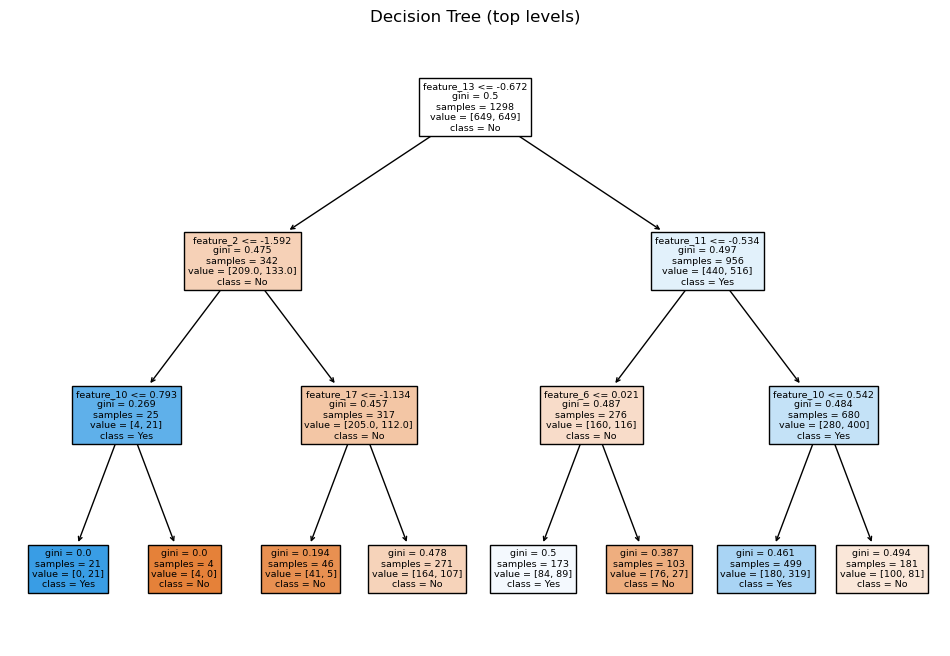

In [38]:
if hasattr(best_model.named_steps['clf'],'tree_'):
    plt.figure(figsize=(12,8))

    sample_transformed = best_model.named_steps['pre'].transform(X_train.head(1))
    n_features = sample_transformed.shape[1]
    
    feature_names_for_plot = [f'feature_{i}' for i in range(n_features)]
    
    plot_tree(best_model.named_steps['clf'], max_depth=3, feature_names=feature_names_for_plot, class_names=['No','Yes'], filled=True)
    plt.title('Decision Tree (top levels)')
    plt.show()

In [40]:
print('\nDISCUSSION & INSIGHTS:')
print('- Preprocessing: numeric columns were median-imputed and scaled; nominal columns target-encoded to keep dimensionality manageable. Ordinal columns preserved as integers (1-5) so model can use natural ordering.')
print('- Imbalance handling: tried both class_weight and oversampling; selected the approach with higher CV F1. Oversampling inside pipeline prevents leakage when using cross-validation (we used imblearn pipeline).')
print('- Feature selection: used RandomForest importances to filter low-importance features; reduces overfitting and speeds up training.')
print('- Model selection: Decision Tree with hyperparameter tuning (max_depth, min_samples_split) using GridSearchCV with StratifiedKFold. Metrics used for model selection: F1-score (harmonic mean of precision & recall) because dataset is imbalanced.')


print('\nActionable insights for HR:')
for f in feat_imp.head(7).index:
    print('-', f)
print('\nThese features appear most predictive of attrition; HR interventions could focus on these areas.')


DISCUSSION & INSIGHTS:
- Preprocessing: numeric columns were median-imputed and scaled; nominal columns target-encoded to keep dimensionality manageable. Ordinal columns preserved as integers (1-5) so model can use natural ordering.
- Imbalance handling: tried both class_weight and oversampling; selected the approach with higher CV F1. Oversampling inside pipeline prevents leakage when using cross-validation (we used imblearn pipeline).
- Feature selection: used RandomForest importances to filter low-importance features; reduces overfitting and speeds up training.
- Model selection: Decision Tree with hyperparameter tuning (max_depth, min_samples_split) using GridSearchCV with StratifiedKFold. Metrics used for model selection: F1-score (harmonic mean of precision & recall) because dataset is imbalanced.

Actionable insights for HR:
- Monthly_Income
- Hourly_Rate
- Training_Hours_Last_Year
- Distance_From_Home
- Absenteeism
- Age
- Average_Hours_Worked_Per_Week

These features appear m